Fold RMSE: 1950.0523
Fold RMSE: 2410.2919
Fold RMSE: 1770.7547
Fold RMSE: 2031.8333
Fold RMSE: 588.4469


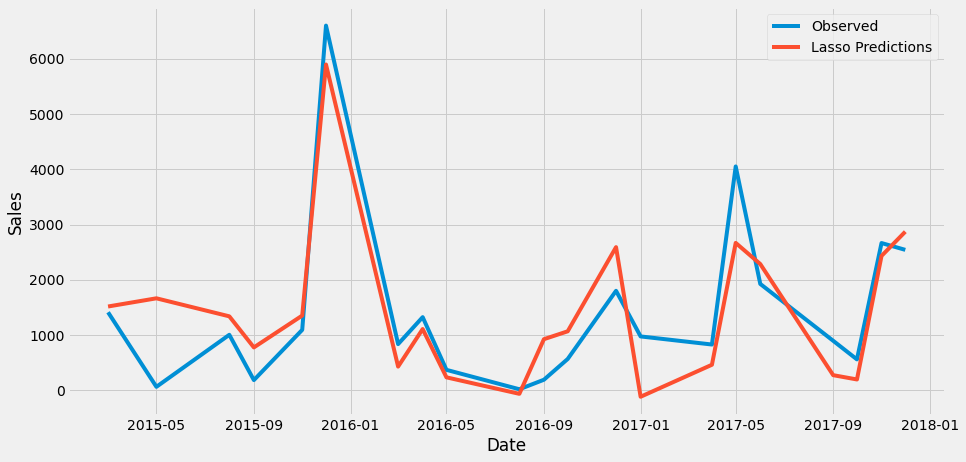

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline

# Load and preprocess the data
df = pd.read_excel("Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

# Drop unnecessary columns
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing with time series data
furniture = furniture.set_index('Order Date')
y = furniture['Sales'].resample('MS').mean()

# Create lag features
for lag in range(1, 13):
    furniture[f'lag_{lag}'] = y.shift(lag)

# Drop NA values after creating lagged features
furniture.dropna(inplace=True)

# Define features and target
X = furniture.drop(columns=['Sales'])
y = furniture['Sales']

# Split the data into train and test sets
tscv = TimeSeriesSplit(n_splits=5)

# Create a pipeline with scaling and Lasso
model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1))
])

# Cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    print(f'Fold RMSE: {rmse:.4f}')

# Fit the model on the entire dataset
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plot the predictions against the actual values
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Observed')
plt.plot(y.index, y_pred, label='Lasso Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
